In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import string 
from nltk.tokenize import word_tokenize, sent_tokenize   #for tokenization
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
import gensim
from nltk import FreqDist
import collections
import re
import joblib

In [2]:
with open('C:\\Users\\mishr\\fr_projects\\Cell_Phones_and_Accessories.json') as data:
    df=json.load(data)

In [3]:
df=pd.DataFrame(df)
df.head(10)

,Rating,Rev_verify,Review_Date,IC,Prod_meta,Reviewer_Name,Review,Rev_summ,Review_timestamp,Useful,Prod_img
0,5,True,"09 1, 2015",B009XD5TPQ,None,Sunny Zoeller,Bought it for my husband. He's very happy with it,He's very happy with,1441065600,None,None
1,5,True,"01 9, 2016",B016MF3P3K,None,Denise Lesley,Great screen protector. Doesn't even seem as ...,Five Stars,1452297600,None,None
2,5,True,"04 21, 2013",B008DC8N5G,None,Emir,Saved me lots of money! it's not gorilla glass...,As long as you know how to put it on!,1366502400,None,None
3,3,True,"02 27, 2013",B0089CH3TM,{'Color:': ' Green'},Alyse,"The material and fit is very nice, but the col...",Good case overall,1361923200,3,None
4,4,True,"12 19, 2013",B00AKZWGAC,None,TechGuy,This last me about 3 days till i have to charg...,Awesome Battery,1387411200,None,None
5,5,True,"12 22, 2016",B00MAWPGMI,{'Color:': ' _Shimmery White'},hannahv_tc,"Love this case, very sturdy!",Five Stars,1482364800,None,None
6,5,False,"08 1, 2016",B00NB7B4GI,None,Nadia,Simple and good quality iPhone 6 case. Fits on...,Simple and good quality iPhone 6 case,1470009600,None,None
7,5,True,"06 22, 2015",B00NMR6N7W,"{'Color:': ' Clear', 'Package Type:': ' Standa...",Jacob,Great screen protector for the money! Paid $1....,Perfect!,1434931200,None,None
8,5,True,"08 13, 2017",B018V60504,{'Color:': ' Black'},Metlman,"Nice charger. One problem, one if the two USB ...",Make sure your Items work before you miss the ...,1502582400,None,None
9,5,False,"04 2, 2015",B00PG8TID6,"{'Color:': ' Black', 'Product Packaging:': ' S...",A. Burke,Most battery packs for iPhones come as a total...,This clever design combines a battery pack int...,1427932800,None,None


In [4]:
df.dtypes

Rating               int64
Rev_verify            bool
Review_Date         object
IC                  object
Prod_meta           object
Reviewer_Name       object
Review              object
Rev_summ            object
Review_timestamp     int64
Useful              object
Prod_img            object
dtype: object

In [5]:
#changing the data type of column Review_Date to date_time format
df['Review_Date']=pd.to_datetime(df['Review_Date'])

In [6]:
df.shape

(760450, 11)

In [7]:
df.columns

Index(['Rating', 'Rev_verify', 'Review_Date', 'IC', 'Prod_meta',
       'Reviewer_Name', 'Review', 'Rev_summ', 'Review_timestamp', 'Useful',
       'Prod_img'],
      dtype='object')

In [8]:
#checking percentage of null values
null_perce=round(((df.isnull().sum())/df.shape[0])*100,3)
print("Null Values found in the dataset\n",null_perce)

Null Values found in the dataset
 Rating               0.000
Rev_verify           0.000
Review_Date          0.000
IC                   0.000
Prod_meta           46.370
Reviewer_Name        0.012
Review               0.070
Rev_summ             0.047
Review_timestamp     0.000
Useful              91.821
Prod_img            97.607
dtype: float64


In [9]:
#dropping 'Prod_img' and 'Useful' columns as they have more than 90% null values
#dropping 'Review_timestamp' column as it contain unix time and we already have a column for time
product=df.drop(['Prod_img','Useful','Review_timestamp'],axis=1)

In [10]:
#dropping null values
product.dropna(inplace=True)

In [11]:
print('Earlier Shape was= ',df.shape,'\nNew shape=',product.shape)

Earlier Shape was=  (760450, 11) 
New shape= (407303, 8)


In [12]:
product.info()

<class 'pandas.core.frame.DataFrame'>
Index: 407303 entries, 3 to 760448
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Rating         407303 non-null  int64         
 1   Rev_verify     407303 non-null  bool          
 2   Review_Date    407303 non-null  datetime64[ns]
 3   IC             407303 non-null  object        
 4   Prod_meta      407303 non-null  object        
 5   Reviewer_Name  407303 non-null  object        
 6   Review         407303 non-null  object        
 7   Rev_summ       407303 non-null  object        
dtypes: bool(1), datetime64[ns](1), int64(1), object(5)
memory usage: 25.2+ MB


In [13]:
product.columns

Index(['Rating', 'Rev_verify', 'Review_Date', 'IC', 'Prod_meta',
       'Reviewer_Name', 'Review', 'Rev_summ'],
      dtype='object')

In [14]:
#rearranging the columns
product=product[['IC','Reviewer_Name','Prod_meta','Review','Rev_summ','Rating','Review_Date','Rev_verify']]

In [15]:
product.sort_values(by='IC', ascending=False)

,IC,Reviewer_Name,Prod_meta,Review,Rev_summ,Rating,Review_Date,Rev_verify
256200,B01HJBS5C2,KC1,{'Color:': ' Black Shell Holster'},Much nicer than my last case. Its been 5 mont...,Very nice,5,2017-04-12,True
667686,B01HJBS5C2,Mark E. Weber,{'Color:': ' Black Shell Holster'},Fits on phone easily. Clips to belt or pocket....,My favorite style for smart phones,5,2017-08-03,True
210315,B01HJBS5C2,Juan Frausto,{'Color:': ' Black Shell Holster'},While the case itself does not offer much in t...,Finally a holster case that fits my needs. Mostly,4,2016-07-22,True
426412,B01HJBS5C2,Bill McLean,{'Color:': ' Black Shell Holster'},"I can't set volume, or use the camera, with th...",DISAPPOINTING,1,2016-10-31,True
337487,B01HJBS5C2,A.E.,{'Color:': ' Black Shell Holster'},"Product seemed decent quality, but fit was so ...",Too tight! Returned,2,2017-02-08,True
...,...,...,...,...,...,...,...,...
737569,961301375X,preferred custimer Linda Beth,{'Color:': ' White'},Works great no problem. I like that it charges...,nice,5,2014-05-18,True
436472,961301375X,Perry W. Wise,{'Color:': ' White'},this was a complete waste of money. i keep try...,junk,1,2014-11-20,True
44978,961301375X,only,{'Color:': ' White'},Order shipped quickly and was exactly as adver...,Simple charger,5,2014-05-24,False
230815,7508492919,eladia paz,{'Color:': ' Bling'},Happy it,Four Stars,4,2015-02-15,True


In [16]:
#checking numbers of unique value in IC,Reviewer_Name,Rating
list1=['IC','Reviewer_Name','Rating','Rev_verify']
for i in list1:
    unique=product[i].nunique()
    vc=product[i].value_counts()
    print('\n-----No of Unique value in',i, '=',unique,'\nand value counts=\n\n',vc)


-----No of Unique value in IC = 21012 
and value counts=

 B00VH88CJ0    1124
B005NF5NTK    1104
B019PV2I3G    1033
B00X5RV14Y    1018
B00P7N0320    1011
              ... 
B00BZNA24A       1
B006XKYHX2       1
B006JQGSKA       1
B00ITD6JUK       1
B014GTYKEM       1
Name: IC, Length: 21012, dtype: int64

-----No of Unique value in Reviewer_Name = 112270 
and value counts=

 Amazon Customer       14314
Kindle Customer        1202
John                    588
Chris                   567
Mike                    530
                      ...  
Duel Tool and Gage        1
kolton davis              1
lightstream               1
Thyra                     1
Jeffrey Miller            1
Name: Reviewer_Name, Length: 112270, dtype: int64

-----No of Unique value in Rating = 5 
and value counts=

 5    258927
4     66833
3     35058
1     26610
2     19875
Name: Rating, dtype: int64

-----No of Unique value in Rev_verify = 2 
and value counts=

 True     357471
False     49832
Name: Rev_verify, dt

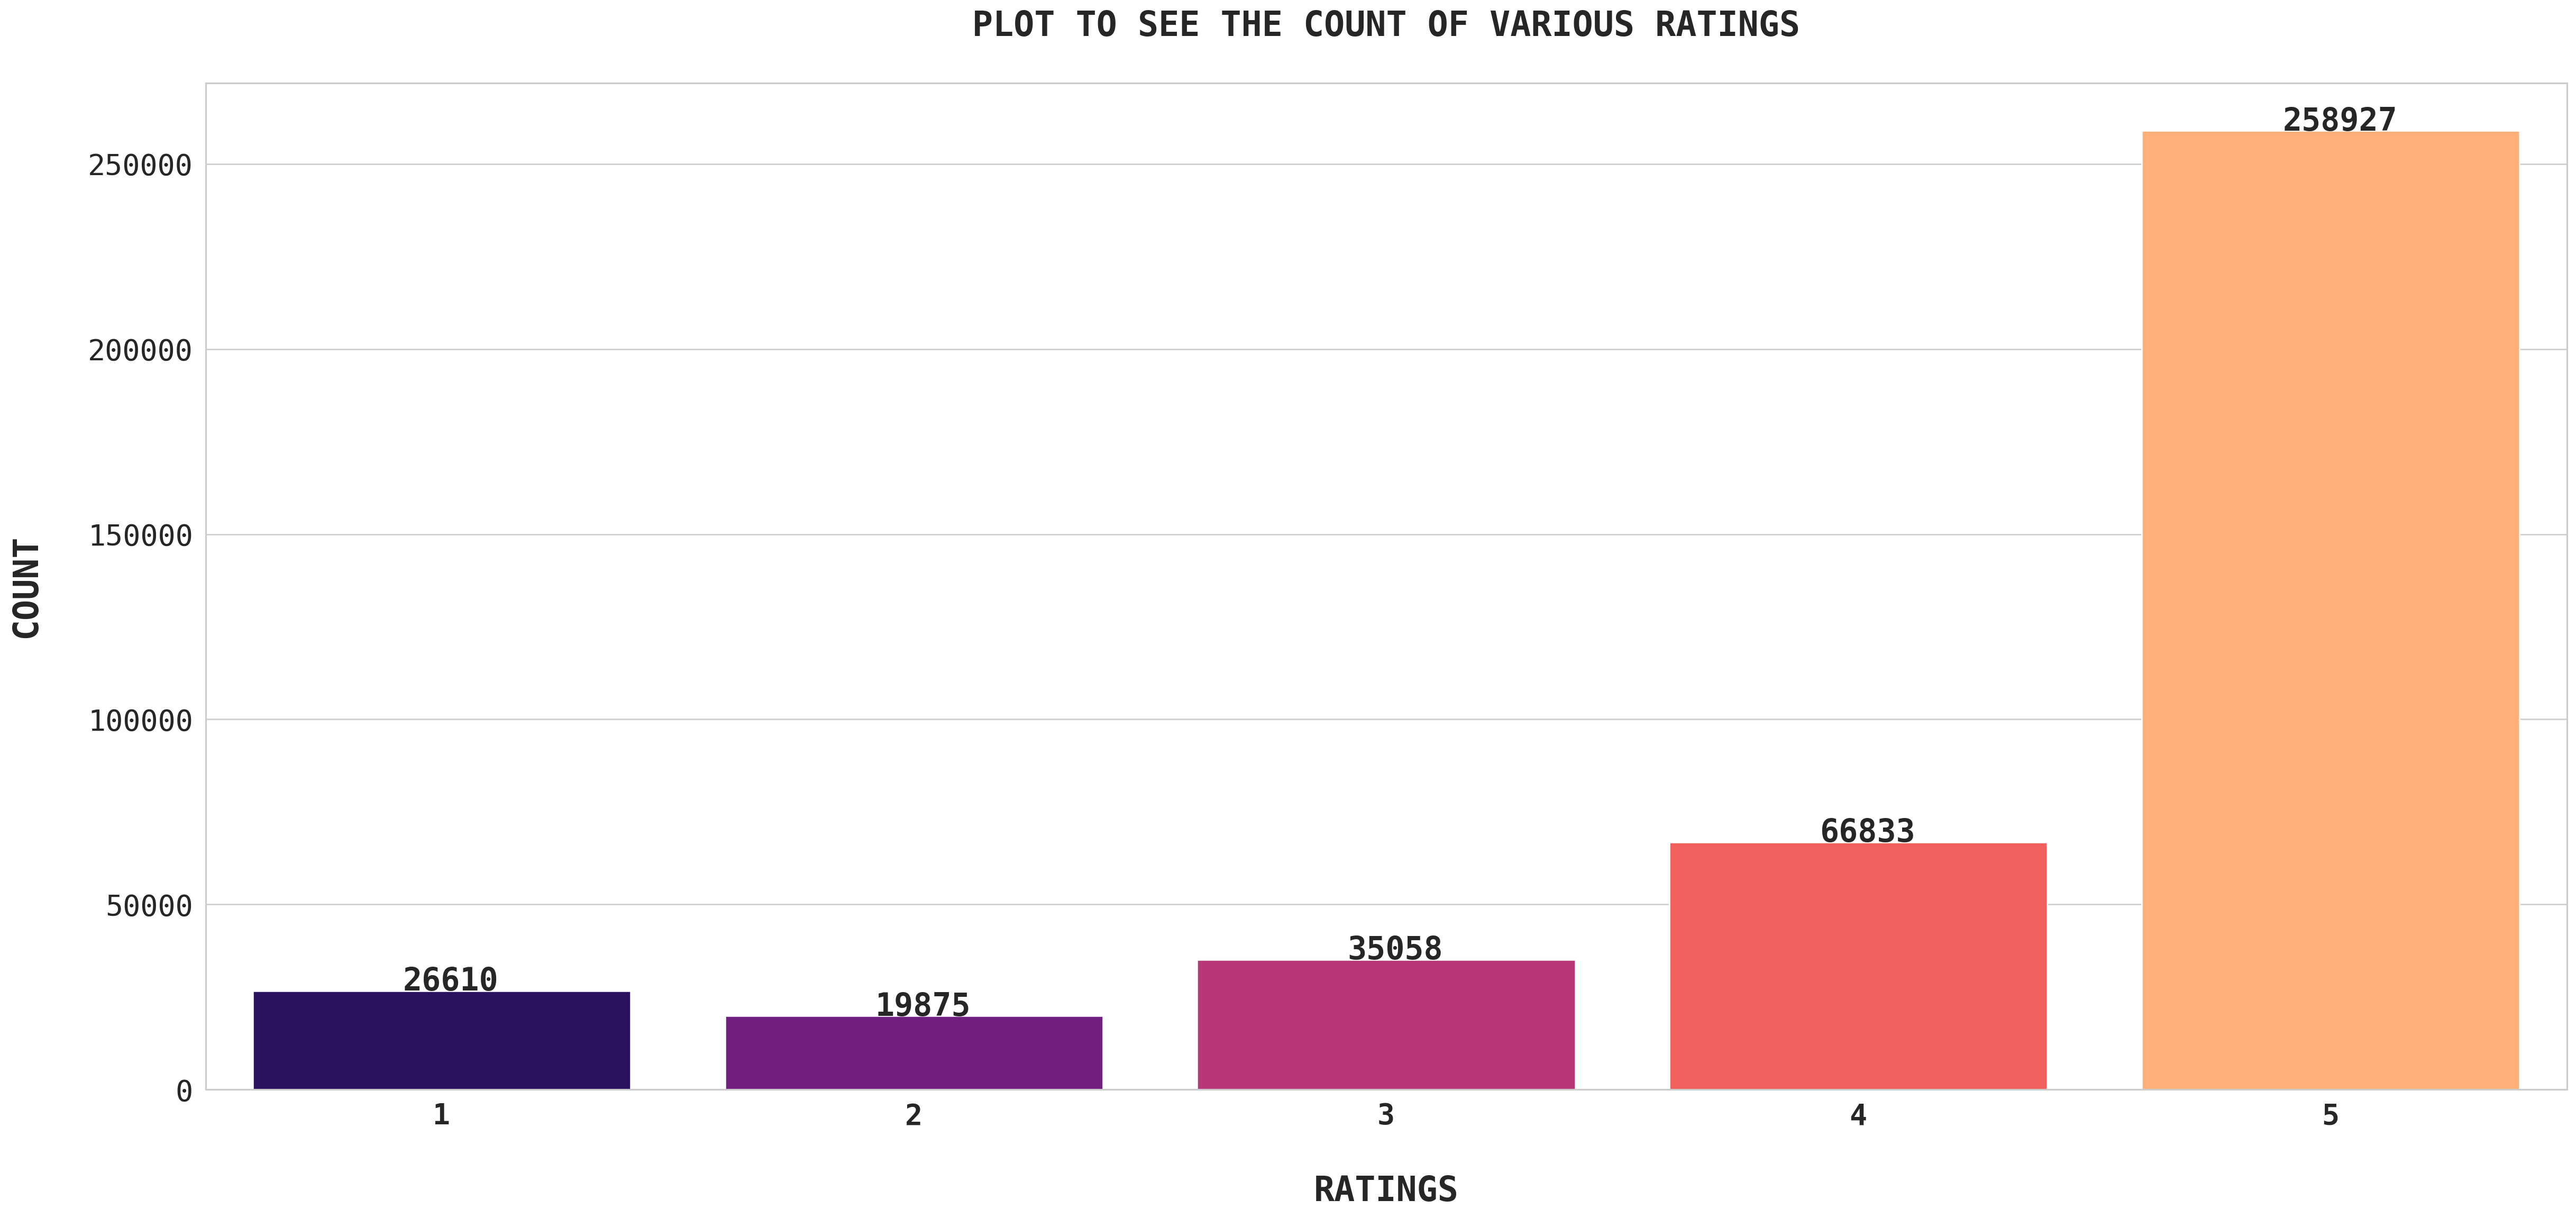

In [17]:
plt.figure(figsize=(32,14),dpi=180)
sns.set(context='notebook',style='whitegrid',palette='bright',font='monospace',font_scale=2)
m=sns.countplot(x='Rating',data=product,orient='v',palette='magma',saturation=35)
m.set_xticklabels(m.get_xticklabels(),rotation=0,weight='bold')
for i in m.patches:
    m.annotate(format(i.get_height(),'.0f'),(i.get_x()+i.get_width()/2,i.get_height()),xytext=(7,7),ha='center',
                   weight='bold', rotation=0,va='center',textcoords='offset points')
plt.xlabel('\nRATINGS',fontsize=26,weight='bold')
plt.ylabel('COUNT\n',fontsize=26,weight='bold')
plt.title('PLOT TO SEE THE COUNT OF VARIOUS RATINGS\n',fontsize=26,weight='bold')
plt.show()

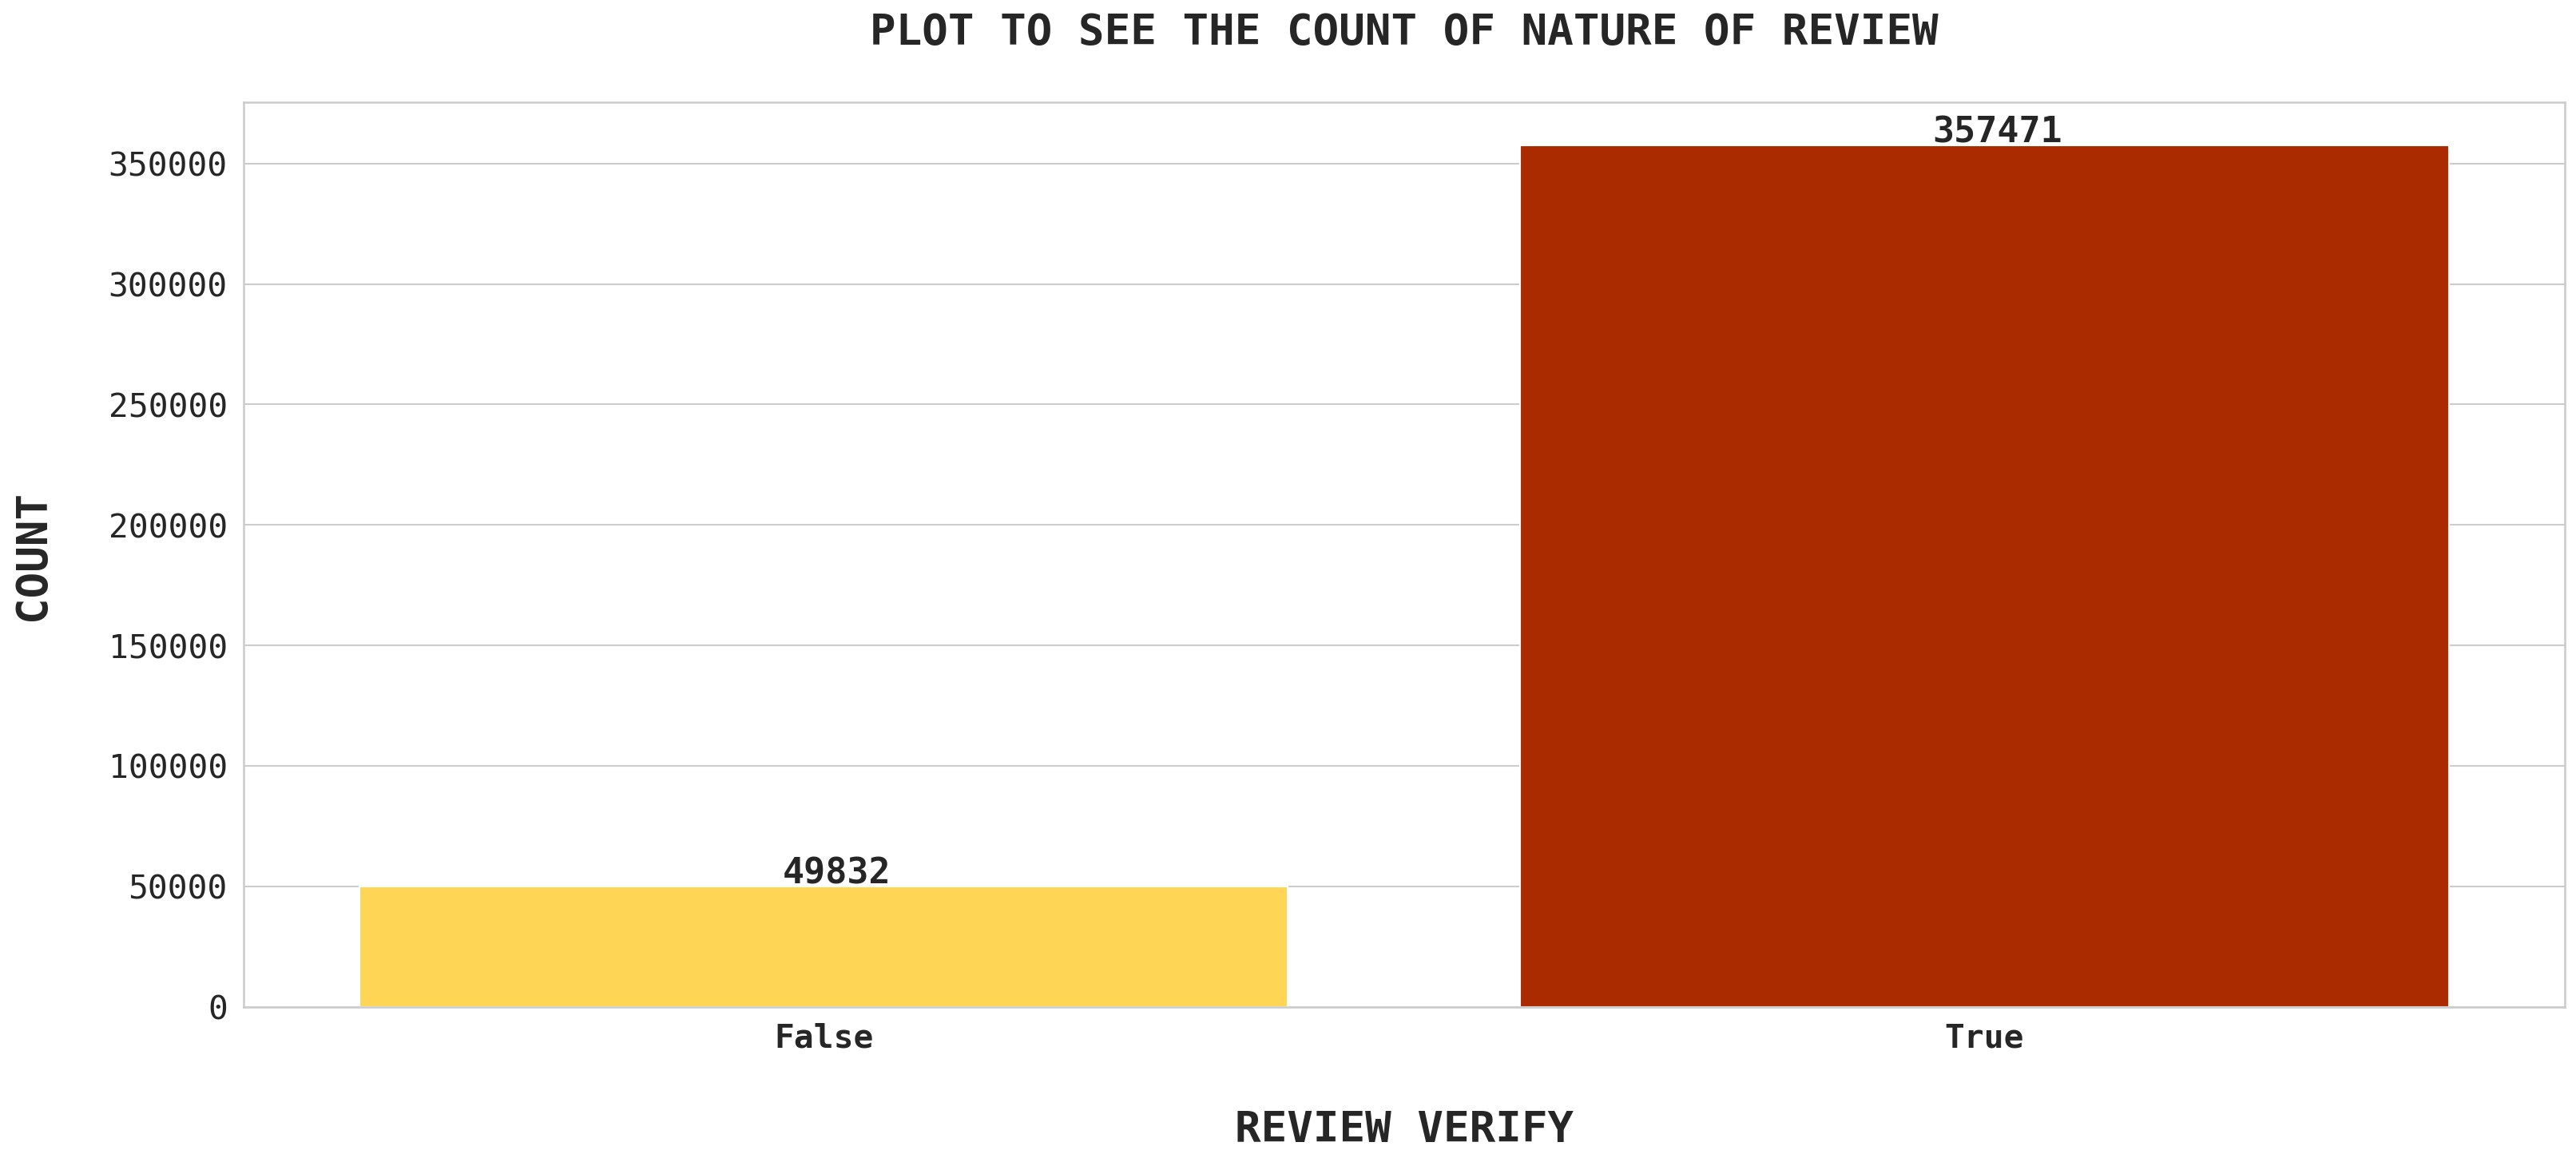

In [18]:
plt.figure(figsize=(25,10),dpi=150)
sns.set(context='notebook',style='whitegrid',palette='bright',font='monospace',font_scale=1.8)
m=sns.countplot(x='Rev_verify',data=product,orient='v',palette='afmhot_r',saturation=35)
m.set_xticklabels(m.get_xticklabels(),rotation=0,weight='bold')
for i in m.patches:
    m.annotate(format(i.get_height(),'.0f'),(i.get_x()+i.get_width()/2,i.get_height()),xytext=(8,8),ha='center',
                   weight='bold', rotation=0,va='center',textcoords='offset points')
plt.xlabel('\nREVIEW VERIFY',fontsize=26,weight='bold')
plt.ylabel('COUNT\n',fontsize=26,weight='bold')
plt.title('PLOT TO SEE THE COUNT OF NATURE OF REVIEW\n',fontsize=26,weight='bold')
plt.show()

In [19]:
product.describe(include=object)

,IC,Reviewer_Name,Prod_meta,Review,Rev_summ
count,407303,407303,407303,407303,407303
unique,21012,112270,26250,346647,203408
top,B00VH88CJ0,Amazon Customer,{'Color:': ' Black'},good,Five Stars
freq,1124,14314,53893,2111,83556


</br> </br>
</br> </br>

**REMOVING REVIEWS WITH LESS THAN 3 WORDS**
</br> </br>
</br> </br>

In [20]:
remove_reviews = []
index=[]
for i in range(len(product)):
    reviews = str(product["Review"][i])  
    
    reviews=reviews.split()
    
    if len(reviews)<3:
        remove_reviews.append(product["Review"][i])
        index.append(i)

In [21]:
print('Length of unwanted reviews to be removed= ',len(remove_reviews))

Length of unwanted reviews to be removed=  49174


In [22]:
#visualizing reviews whose length are less than 3
sample=random.sample(remove_reviews,10)
sample

['good',
 'fit great',
 'Excelent',
 'Love it!',
 'Meh!',
 'thank you',
 'Good',
 'good',
 'OtterBox ROCKS!!!',
 'Fit perfectly.']

In [23]:
sample=random.sample(index,10)
sample

[344659, 129691, 21275, 164894, 102445, 202209, 147661, 373650, 285925, 73654]

In [24]:
#checking the review using index based location method
product.iloc[sample[7]]

IC                               B00S5PZIMW
Reviewer_Name                Wendell Hussey
Prod_meta        {'Color:': ' Black/Black'}
Review                        Great product
Rev_summ                      Great product
Rating                                    5
Review_Date             2015-07-11 00:00:00
Rev_verify                             True
Name: 697423, dtype: object

In [25]:
#dropping the values of rows where the length of review is less than 3
product.drop(product.index[index],inplace=True) 

In [26]:
print('New shape after removal of small words=', product.shape)

New shape after removal of small words= (358129, 8)


_***`After removing the reviews whose length are less than 3, There is a reduction in the shape of the dataset earlier the shape was '407303' and now it becomes '358129'`***_

In [27]:
product.reset_index(drop=True,inplace=True)

In [28]:
product.head(6)

,IC,Reviewer_Name,Prod_meta,Review,Rev_summ,Rating,Review_Date,Rev_verify
0,B0089CH3TM,Alyse,{'Color:': ' Green'},"The material and fit is very nice, but the col...",Good case overall,3,2013-02-27,True
1,B00MAWPGMI,hannahv_tc,{'Color:': ' _Shimmery White'},"Love this case, very sturdy!",Five Stars,5,2016-12-22,True
2,B00NMR6N7W,Jacob,"{'Color:': ' Clear', 'Package Type:': ' Standa...",Great screen protector for the money! Paid $1....,Perfect!,5,2015-06-22,True
3,B018V60504,Metlman,{'Color:': ' Black'},"Nice charger. One problem, one if the two USB ...",Make sure your Items work before you miss the ...,5,2017-08-13,True
4,B00PG8TID6,A. Burke,"{'Color:': ' Black', 'Product Packaging:': ' S...",Most battery packs for iPhones come as a total...,This clever design combines a battery pack int...,5,2015-04-02,False
5,B00IJJCQBA,Stephanie,{'Color:': ' Black / Black'},To tight on my phone and the bottom piece was ...,One Star,1,2016-01-14,True


</br> </br>
</br> </br>
</br> </br>
</br> </br>

**VIEWING SOME REVIEWS ALONG WITH THEIR ICs & RATINGS GIVEN TO IT BY CUSTOMERS**

In [29]:
for i in range(5):
    print("\n------Review of",product['IC'][i],';')
    print(product.Review[i].lower())
    print('--Rating =',product.Rating[i])
    print('Given by',product.Reviewer_Name[i].upper())
    print()


------Review of B0089CH3TM ;
the material and fit is very nice, but the color is more of a neon green than i expected or would have liked.
--Rating = 3
Given by ALYSE


------Review of B00MAWPGMI ;
love this case, very sturdy!
--Rating = 5
Given by HANNAHV_TC


------Review of B00NMR6N7W ;
great screen protector for the money! paid $1.50 with free shipping and it arrived way sooner than expected. fits perfect on my iphone 6 and looks better than the $15 screen protector i had on it before. i love the matte finish on it as well. it feels and looks better than the glossy ones. would most definitely buy again and recommend to anyone.
--Rating = 5
Given by JACOB


------Review of B018V60504 ;
nice charger. one problem, one if the two usb slots is misaligned, allowing only one charging slot to be used at a time.
only noticed after the return window was closed.
be very sure that your items are working, so you do not miss the return window. if something should happen after that, well that's 

</br> </br>
</br> </br>

**CHECKING AND PLOTTING THE MOST FREQUENT WORDS USED IN REVIEW SECTION**

In [30]:
def frequency(text,no): 
    words = ' '.join([i for i in text])
    words=words.lower()
    words = words.split()
    distribution= FreqDist(words)  #checking repeation of words in a sentence
    df = pd.DataFrame({'word':list(distribution.keys()), 'count':list(distribution.values())})
    
    data = df.nlargest(columns="count", n = no) 
    
    plt.figure(figsize=(40,20),dpi=120)
    sns.set(context='notebook',style='whitegrid',palette='bright',font='monospace',font_scale=2)
    m=sns.barplot(x='word',y='count',data=data,orient='v',palette='autumn',saturation=35)
    m.set_xticklabels(m.get_xticklabels(),rotation=90,weight='bold')
    for i in m.patches:
        m.annotate(format(i.get_height(),'.0f'),(i.get_x()+i.get_width()/2,i.get_height()),xytext=(5,5),ha='center',
                   weight='bold', rotation=65,va='center',textcoords='offset points')
    plt.xlabel('\nWORDS',fontsize=27,weight='bold')
    plt.ylabel('COUNT\n',fontsize=27,weight='bold')
    plt.title('PLOT TO SEE THE COUNT OF WORDS\n',fontsize=27,weight='bold')
    plt.show()

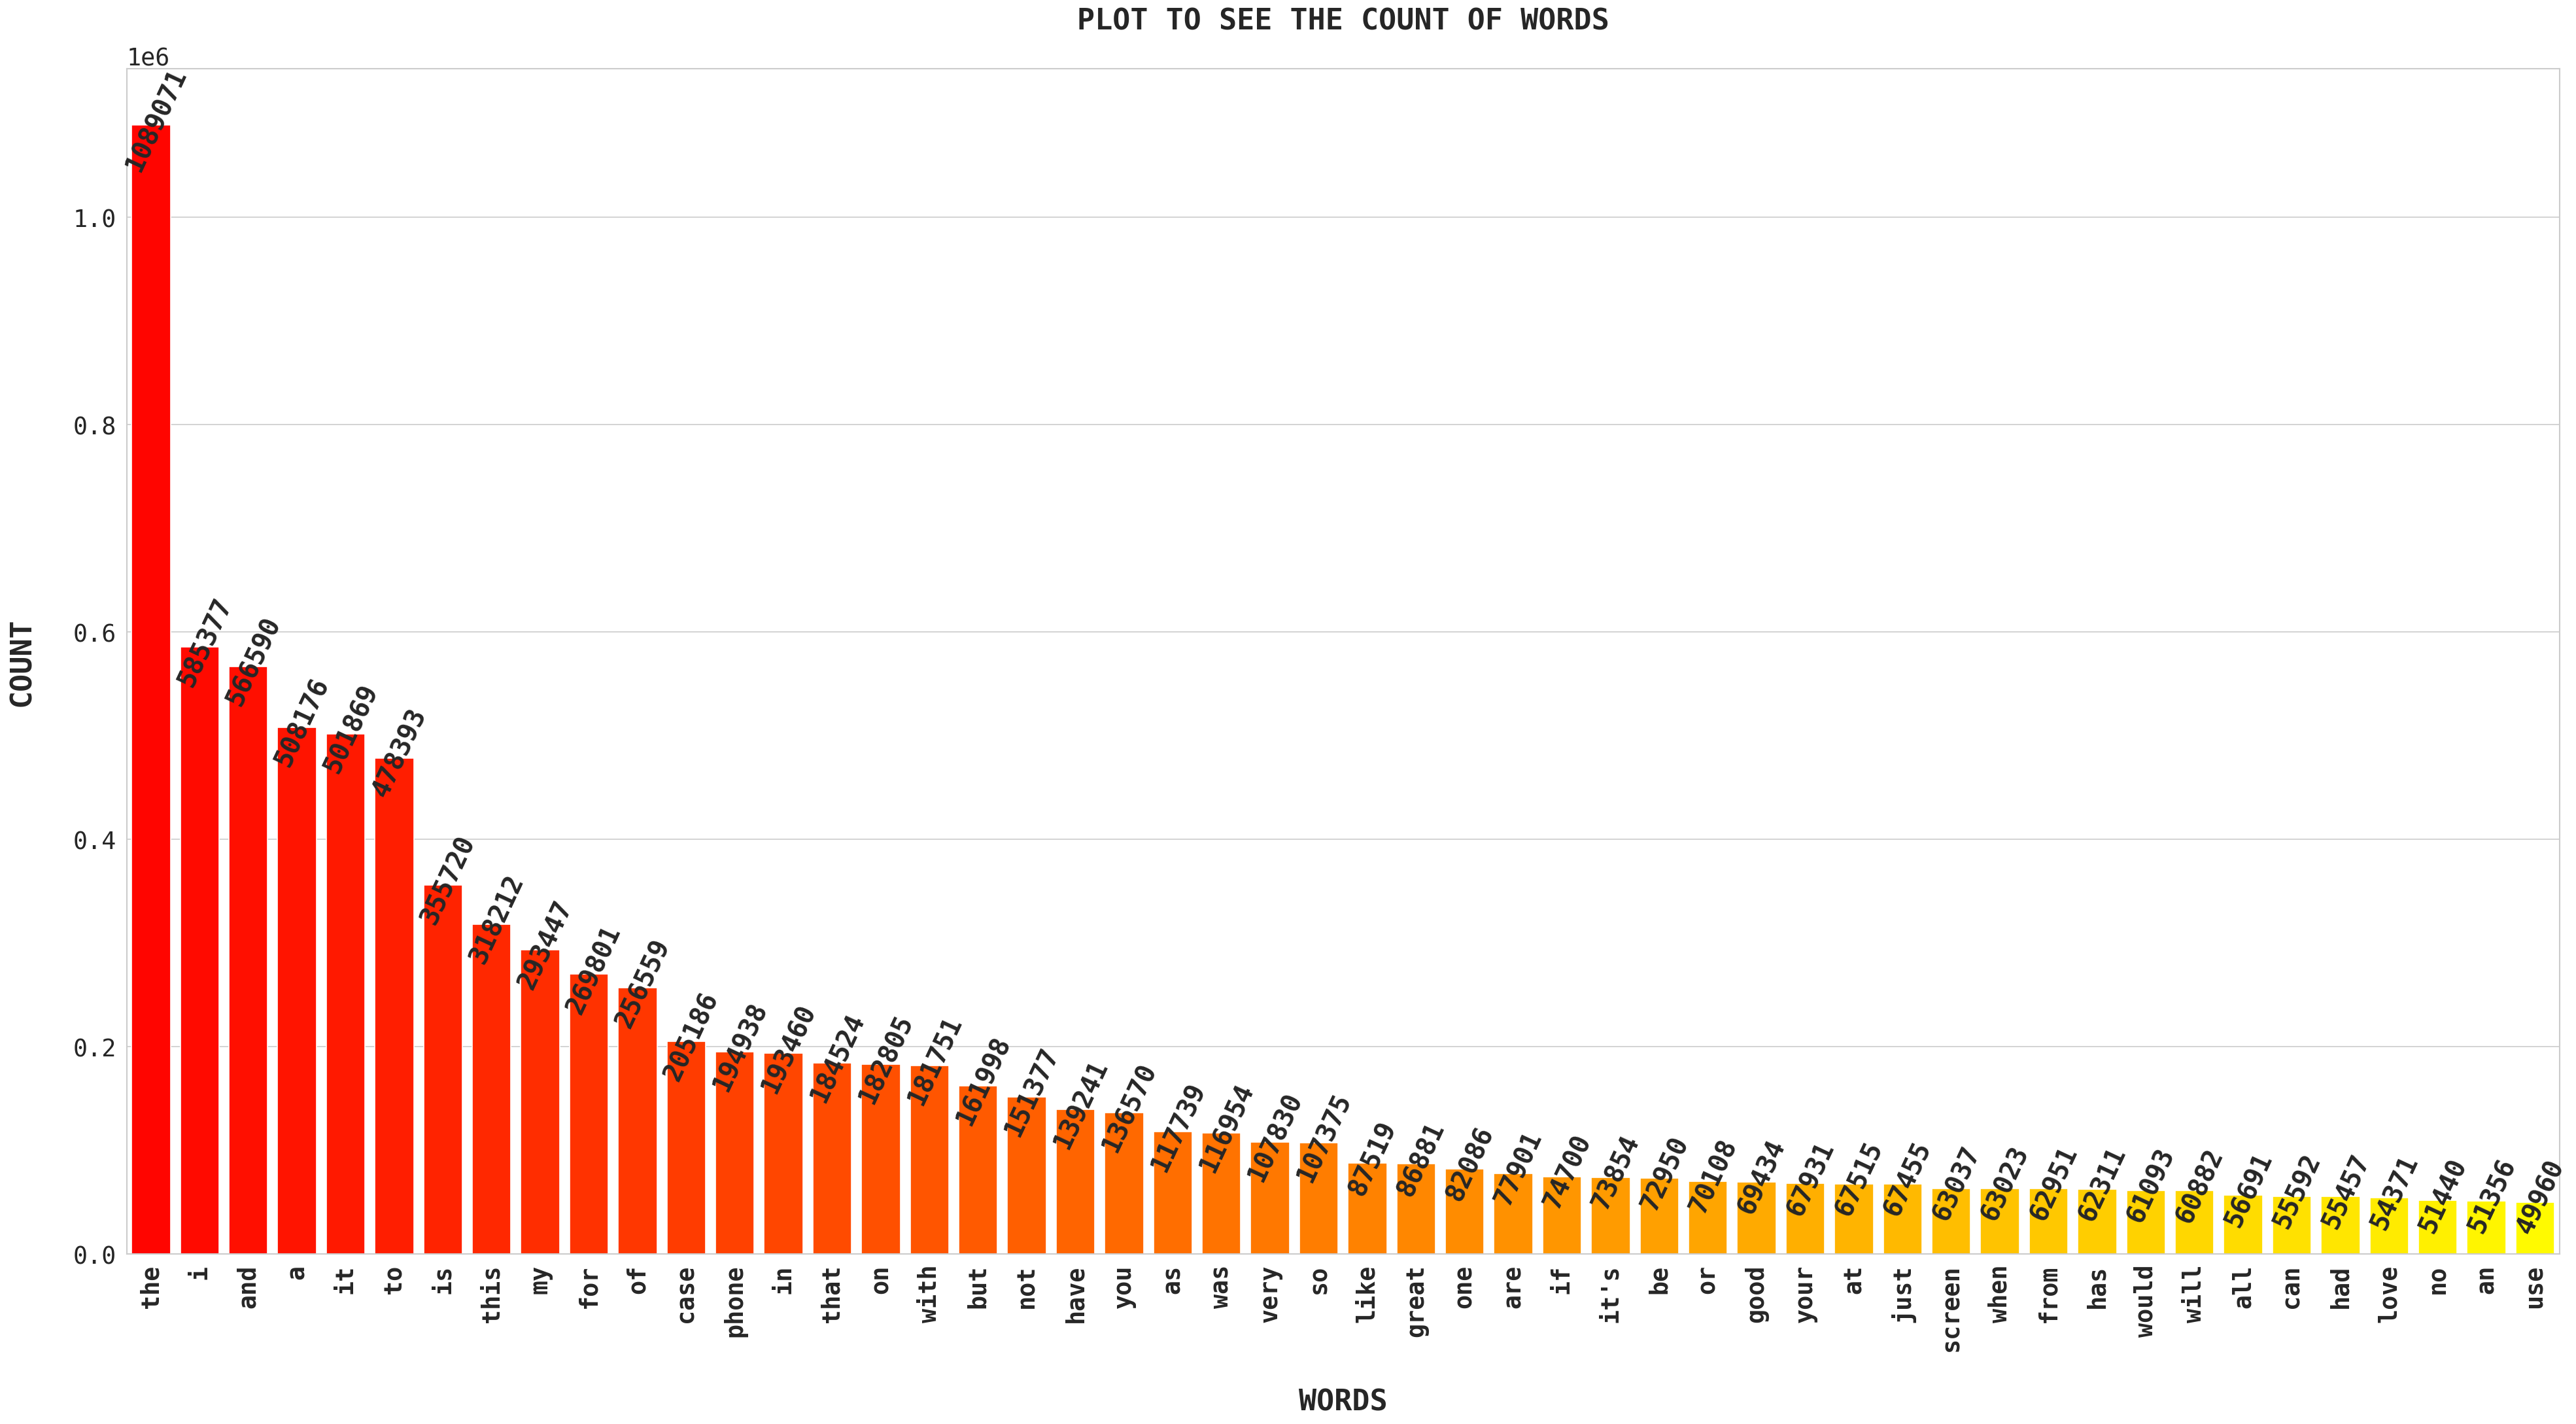

In [31]:
frequency(product['Review'],no=50)

</br> </br>
</br> </br>
_***`so from above we can see that there are a lot of stopwords like "the,i,and,a" etc. have very high frequency and these words must be removed to obtained the proper words`***_
</br> </br>
</br> </br>

</br> </br>
</br> </br>

**PREPROCESSING THE 'REVIEW' COLUMN TO REMOVE STOPWORDS,SYMBOLS,PUNCTUATIONS ETC.**

In [32]:
#ADDING AN EXTRA COLUMN "Review_uncleaned" TO THE DATASET WHICH WILL SHOW THE LENGTH OF THE REVIEWS IN REVIEW COLUMN

product['Review_uncleaned']= product['Review'].str.len().astype('int64')

In [33]:
product.head(5)

,IC,Reviewer_Name,Prod_meta,Review,Rev_summ,Rating,Review_Date,Rev_verify,Review_uncleaned
0,B0089CH3TM,Alyse,{'Color:': ' Green'},"The material and fit is very nice, but the col...",Good case overall,3,2013-02-27,True,109
1,B00MAWPGMI,hannahv_tc,{'Color:': ' _Shimmery White'},"Love this case, very sturdy!",Five Stars,5,2016-12-22,True,28
2,B00NMR6N7W,Jacob,"{'Color:': ' Clear', 'Package Type:': ' Standa...",Great screen protector for the money! Paid $1....,Perfect!,5,2015-06-22,True,347
3,B018V60504,Metlman,{'Color:': ' Black'},"Nice charger. One problem, one if the two USB ...",Make sure your Items work before you miss the ...,5,2017-08-13,True,371
4,B00PG8TID6,A. Burke,"{'Color:': ' Black', 'Product Packaging:': ' S...",Most battery packs for iPhones come as a total...,This clever design combines a battery pack int...,5,2015-04-02,False,1548


In [34]:
stopwords=['i','me','my','myself','we','our','ours','ourselves','you',"you're","you've","you'll","you'd",'href',
           'yours','yourself','yourselves','he','him','his','himself','she',"she's",'her','hers','link','your',
           'herself','it',"it's",'its','itself','they','them','their','theirs','themselves','what','which','linked','eventual'
           'who','whom','this','that',"that'll",'these','how','these','those','am','is','are','was','were','used','thiss',
           'be','been','being','have','has','had','having','do','does','did','done','doing','a','an','the','hold','week',
           'and','but','if','or','because','as','until','while','of','at','by','for','with','about','against','know','tell',
           'between','into','through','during','before','after','above','below','to','from','up','down','in','out','based',
           'on','off','over','under','again','further','then','once','here','there','when','where','why','how','day','work',
           'all','any','both','each','few','more','most','other','some','such','no','nor','not','only','own','same','abov','soon',
           'so','than','too','very','s','t','can','will','just','don',"don't",'should',"should've",'now','d','ll','m','awhile',
           'o','re','ve','y','ain','aren',"aren't",'couldn',"couldn't",'didn',"didn't",'doesn',"doesn't",'hadn','many','worked',
           "hadn't",'hasn',"hasn't",'haven',"haven't",'isn',"isn't",'mightn',"mightn't",'mustn',"mustn't",'needn','think','sometimes',
           "needn't",'shan',"shan't",'shouldn',"shouldn't",'wasn',"wasn't",'weren',"weren't",'won',"won't",'wouldn','cant','together',
           "wouldn't",'looked',"What's",'although','upright','bit','right','state',"i've",'much','more',"there's","You've",'add','added',
           'got',"i'd",'everything','true','yes','moreover','would','could','like','but','couldnt',"i'm",'able','back','adding',
           'get','still','ought','perhaps','without','away','onto','ive','must','see','went','saw','havent','whats','id','said',
           'let','never','yet','im','go','thatll','theyre','came','youll','come','word','noone','thank','thanks',"now!","then?",
           "that's","than",'is','more', 'so','on','can','all','as', 'a',"don't", "doesn't","it's","I'm","that's","there's",'know',
           'purchased','nice','take','year','purchased',"what's","where's","it's","who's","i'm","she's","he's","they're",'says',
           "who're","ain't","wouldn't","shouldn't","can't","couldn't","won't","will",'didnt','really','used','using','month','say',
           'received','hand','since','give','dont','well','doesnt','also','feel','enough','want','keep','made','around','even',
           'need','thing','another','seller','though','cant','however','make','protection','protect','take','protector','looking',
           'vary','easily','item','seems','days','different','bought','told','yesterday','others','something','everything','off','offs','take','took','taken',
          "wayyyy","wich","wold","wthe",'none','time','neither','nothing','website','therefore','become','every','wasnt','kept','always']


print("Length of stopwords=",len(stopwords))

Length of stopwords= 368


In [35]:
def preprocess(text):
    processed=[]
    
    lower=str(text).lower().replace(r'\n'," ").replace(r'\s+', ' ').replace(r'\d+(\.\d+)?', '')
    #removing \n,large white space and leading_trailing white spaces and numbers by single white space
    lower=lower.replace(r'^.+@[^\.].*\.[a-z]{2,}$',' ') #replacing any mailids by whitespace
    punct=lower.translate(str.maketrans('', '', string.punctuation))  #remove punctuation
    digit=punct.translate(str.maketrans('', '', string.digits))       #remove digits any remaining
    word= word_tokenize(digit, "english")    
    for i in word:
        if i not in stopwords and len(i)>3:   #considering token whose lenth
            lemma=WordNetLemmatizer().lemmatize(i)
            processed.append(lemma)
    return(" ".join([x for x in processed])).strip()

***CHECKING THE FUNCTION CREATED ABOVE***

In [36]:
trail=['Xiaomi MI7, ready to launch in February 2018, is the latest smartphone in India with 6.1 inches (15.49 cm) \
touchscreen display by Xiaomi. Designed with the updated technology, Xiaomi MI7 works on Android v7.0 (Nougat) operating \
system and features Dual-color LED Flash, 2160 x 3840 pixels screen resolution, 13 MP front camera and what not, feel \
that too at the best price in India. Xiaomi brings to you its newest development, Xiaomi MI7 with good battery backup, \
camera, speakers and much more.. purchased it and I am writing this review after 20 days of usage..1st feature of this phone is the super \
amoled display.. Performance is good, handles heavy games with ease. Cameras are great too. yeee thank you @store']
print("\n\n Processed document: \n")  #using the function to see the changes
print(preprocess(trail))



 Processed document: 

xiaomi ready launch february latest smartphone india inch touchscreen display xiaomi designed updated technology xiaomi work android nougat operating system feature dualcolor flash pixel screen resolution front camera best price india xiaomi brings newest development xiaomi good battery backup camera speaker writing review usagest feature phone super amoled display performance good handle heavy game ease camera great yeee store


In [37]:
%%time
processed_docs = []
for i in product.Review:
    processed_docs.append(preprocess(i))

Wall time: 2min 33s


In [38]:
print("Length of cleaned text=\t",len(processed_docs))
print(processed_docs[:21]) #CHECKING FIRST 6 

Length of cleaned text=	 358129
['material color neon green expected liked', 'love case sturdy', 'great screen money paid free shipping arrived sooner expected fit perfect iphone look better screen love matte finish feel look better glossy one definitely recommend anyone', 'charger problem slot misaligned allowing charging slot noticed return window closed sure item working miss return window happen thats continue brick mortar store bestbuy', 'battery pack iphones totally separate device hunk plastic remember recharge lenmar iphone case actually becomes part iphone act battery pack work hard durable case remember charge phone separately phone case indefinitely phone battery pack recharge plug night phone battery start simply press green glowing button case recharges phone case indicates reserve battery power left might worry battery pack bulk iphone case half inch length inch thickness personally found problem size pocket bigger add surprisingly little weight case slip deal remove ofte

In [39]:
#CREATING A DATAFRAME
processed= pd.DataFrame({'Cleaned REVIEW' : processed_docs })

In [40]:
product['cleaned_review']=processed

In [41]:
product['Cleaned Review length']=product['cleaned_review'].str.len()

In [42]:
product.sample(3)

,IC,Reviewer_Name,Prod_meta,Review,Rev_summ,Rating,Review_Date,Rev_verify,Review_uncleaned,cleaned_review,Cleaned Review length
167088,B0194M62YW,Alex,{'Color:': ' Note 4 Glass 2-Pack'},This screen protector would not cover fully th...,That would make my finger bump in the glass ev...,2,2016-08-02,True,256,screen cover fully screen note instead edge sc...,127
343365,B01E0ZYXQ2,Court,{'Size:': ' 8 Pack'},Good screen protectors,Five Stars,5,2017-12-26,True,22,good screen protector,21
192245,B01DLYF1OQ,Large Lau,{'Color:': ' iPhone 7 Plus/6S Plus/6 Plus'},Amazing product fits totally fine behind a pho...,Excellent device,5,2018-02-15,True,340,amazing product fit totally fine behind phone ...,185


In [43]:
#CALCULATING THE NUMBER OF TEXTS removed
print('Original Length = ', product['Review_uncleaned'].sum())
print('Clean Length =  ', product['Cleaned Review length'].sum())
print('Total Reduction = ',product['Review_uncleaned'].sum()-product['Cleaned Review length'].sum())

Original Length =  107170132
Clean Length =   51457859
Total Reduction =  55712273


</br> </br>
</br> </br>
**CHECKING AND PLOTTING THE MOST FREQUENT WORDS FOUND IN _'CLEANED REVIEW'_ COLUMN AFTER CLEANING THE _'REVIEW COLUMN'_**

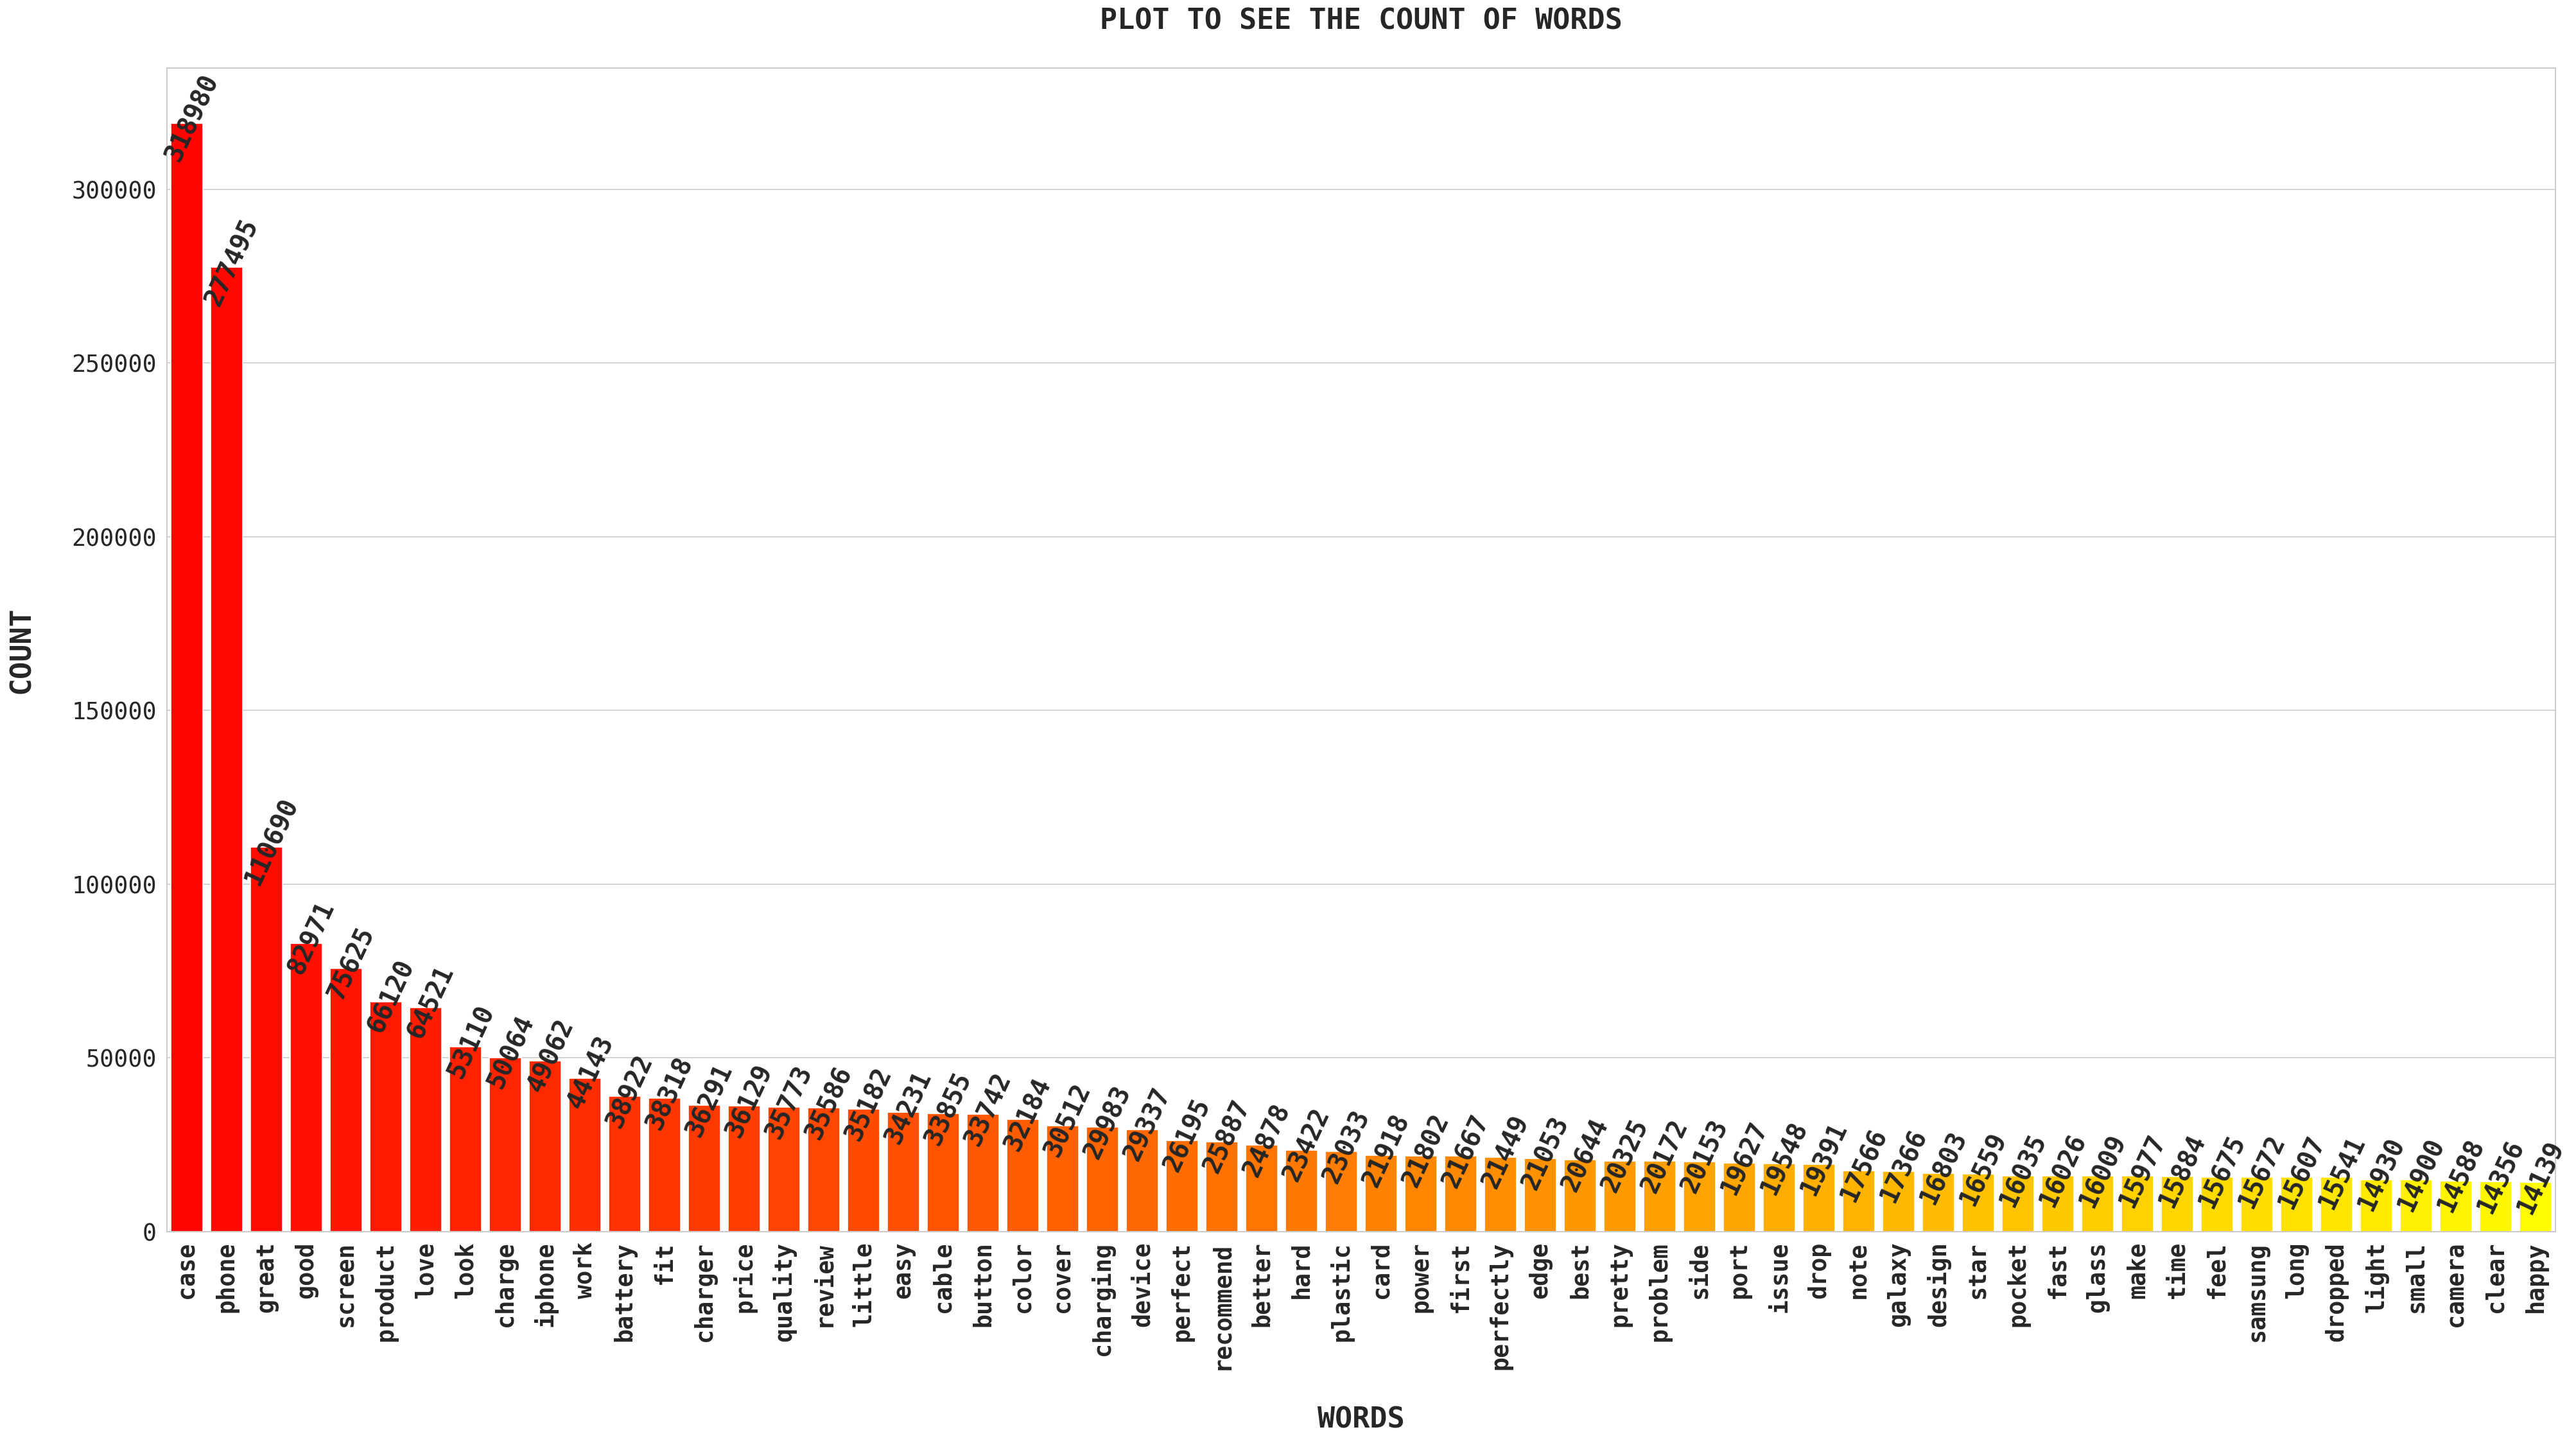

In [44]:
frequency(product['cleaned_review'],no=60)



**CREATING A NEW DATAFRAME CONTAINING UNIQUE ICs, REVIEWS FOR EACH ICs, TOTAL RATING GIVEN TO EACH PRODUCT<br/>**
<br/>
<br/>
*`COLUMN NAMED  "maximum" ,WILL CONTAIN THE SUM OF NUMBERS OF 5 & 4 STAR RATINGS GIVEN TO A PRODUCT BY CUSTOMERS`<br/>* 

*`COLUMN NAMED  "average" ,WILL CONTAIN THE SUM OF NUMBERS ONLY OF 3 STAR RATINGS GIVEN TO A PRODUCT BY CUSTOMERS`<br/>* 

*`COLUMN NAMED  "minimum" ,WILL CONTAIN THE SUM OF NUMBERS OF 2 & 1 STAR RATINGS GIVEN TO A PRODUCT BY CUSTOMERS`<br/>*

In [45]:
ic=product["IC"].value_counts().index.tolist()

In [46]:
len(ic)

20948

In [47]:
%%time
dictionary={}
dictionary['IC']=[]
dictionary['DESCRIPTION']=[]
dictionary['REVIEW']=[]
dictionary['MAXIMUM']=[]
dictionary['AVERAGE']=[]
dictionary['MINIMUM']=[]

for x in ic:
    i=0
    j=0
    k=0
      
    dictionary['IC'].append(x)   
                                                    #it'll contain the unique ICs of the product
    
    desc=product.loc[product['IC']==x,'Prod_meta'].values
    dictionary['DESCRIPTION'].append(desc[0])
                                                    
                                                    #it'll contain the meta data for each product 
    review=product.loc[product['IC']==x,'cleaned_review'].values
    review=str(list(review))
    dictionary['REVIEW'].append(review)                          
        #it'll contain all the preprocessed and cleaned review for each product in a single cell
    
    rates=product.loc[product['IC']==x,'Rating'].values
    for rate in rates:
        if rate>3:
            i=i+1 
        #'i' will contain the total number of 5 and 4 star given to a product & will be dispalyed on column 'maximum'
    
        elif rate==3:
            j=j+1            
        #'j' will contain the total number of 3 star given to a product & will be dispalyed on column 'average'
   
        else:
            k=k+1            
        #'k' will contain the total number of 2 and 1 star given to a product & will be dispalyed on column 'minimum'
                
    dictionary['MAXIMUM'].append(i)  
    dictionary['AVERAGE'].append(j)
    dictionary['MINIMUM'].append(k)

Wall time: 18min 53s


In [48]:
print('NUMBER OF UNIQUE IC= ',len(dictionary['IC']),'\nNUMBER OF REVIEWS= ',len(dictionary['REVIEW']))

NUMBER OF UNIQUE IC=  20948 
NUMBER OF REVIEWS=  20948


In [49]:
crit=pd.DataFrame(dictionary)

_`Here we will use Topic Modelling with Latent Dirichlet Allocation (LDA) & GENSIM to obtain the summerised texts.
The Topic Modeling is a process to identify topics present in a text and derive the hidden patterns shown by a text corpus.`_

</br>**_GENERATING A FUNCTION TO PREPROCESS THE DATA AND CREAT LEMMATIZED TOKENS OUT OF THEM_**</br>

In [50]:
def preprocess(text):
    processed=[]
    text=text.lower().replace(r'\n'," ").replace(r'\s+', ' ').replace(r'\d+(\.\d+)?', '') 
     #removing \n,large white space and leading_trailing white spaces and numbers by single white space
           
    punct=text.translate(str.maketrans('', '', string.punctuation))  #remove punctuation
    digit=punct.translate(str.maketrans('', '', string.digits))      #remove digits
    word= word_tokenize(digit, "english")
    for i in word:
        if i not in stopwords and len(i)>=3:
            lemma=WordNetLemmatizer().lemmatize(i)
            processed.append(lemma)
    return processed

**ADDING TOKENISED WORDS TO THE MAIN DATAFRAME**

In [51]:
crit['TOKENIZED_REVIEW'] = crit['REVIEW'].apply(preprocess) 

In [52]:
crit.sample(5)

,IC,DESCRIPTION,REVIEW,MAXIMUM,AVERAGE,MINIMUM,TOKENIZED_REVIEW
15929,B011R4T3P0,{'Color:': ' Hello Kitty pink'},['remember hello kitty ordered pink hello kitt...,3,0,1,"[remember, hello, kitty, ordered, pink, hello,..."
15094,B017FWZL6I,{'Color:': ' Clear'},['pretty good first arrive proper cutout trigg...,2,0,2,"[pretty, good, first, arrive, proper, cutout, ..."
7602,B00Q1UW81M,{'Color:': ' Purple'},"['wife like', 'great great design love', 'work...",9,1,0,"[wife, great, great, design, love, great, tabl..."
859,B013C6EZO0,{'Color:': ' A Grey/Turquoise'},['cute love color allow phone charge charging ...,54,10,6,"[cute, love, color, allow, phone, charge, char..."
1046,B004YM6FFY,"{'Size:': ' iPhone 4s/4', 'Color:': ' White / ...",['lasted age long upgraded phone change cover ...,55,2,4,"[lasted, age, long, upgraded, phone, change, c..."


In [53]:
processed=crit.TOKENIZED_REVIEW

In [54]:
#creating a dictionary
dictionary = gensim.corpora.Dictionary(processed)

In [55]:
print (dictionary)

Dictionary(95659 unique tokens: ['ability', 'abroad', 'absence', 'absolute', 'absolutely']...)


In [56]:
#checking the first 30 key value pairs of the dictionary created
count=0
for k,v in dictionary.iteritems():
    print (k, v)
    count +=1
    if count >15:
        break

0 ability
1 abroad
2 absence
3 absolute
4 absolutely
5 acceptable
6 accepted
7 access
8 accessory
9 accident
10 accidental
11 accidentally
12 accidently
13 accommodate
14 accordingly
15 account


In [57]:
#removing rare and repetitive words
dictionary.filter_extremes(no_below=3,no_above=0.02,keep_n=95000)

`removing rare token whose repetition is less than 3 in documents and repetitive words whose repetition is higer than 2% of entire document`

In [58]:
print (dictionary)

Dictionary(22781 unique tokens: ['abroad', 'absence', 'acceptable', 'accepted', 'accidently']...)


In [59]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed]

In [60]:
#preview of words and their apperance in the topics
document_num = 1
bow_doc_x = bow_corpus[document_num]

for i in range(len(bow_doc_x)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_x[i][0], 
                                                     dictionary[bow_doc_x[i][0]],
                                                     bow_doc_x[i][1]))

Word 5 ("accordingly") appears 2 time.
Word 11 ("adaptive") appears 1 time.
Word 12 ("address") appears 1 time.
Word 23 ("airport") appears 1 time.
Word 29 ("amazed") appears 1 time.
Word 33 ("amp") appears 28 time.
Word 34 ("ampere") appears 2 time.
Word 39 ("anger") appears 1 time.
Word 40 ("ankerdirect") appears 3 time.
Word 41 ("ankers") appears 21 time.
Word 47 ("anybody") appears 1 time.
Word 48 ("apologized") appears 1 time.
Word 52 ("appropriate") appears 2 time.
Word 57 ("assorted") appears 1 time.
Word 61 ("astro") appears 1 time.
Word 70 ("automatic") appears 2 time.
Word 76 ("backed") appears 1 time.
Word 99 ("bike") appears 1 time.
Word 106 ("blow") appears 3 time.
Word 109 ("boost") appears 3 time.
Word 112 ("brag") appears 1 time.
Word 113 ("braided") appears 2 time.
Word 115 ("breeze") appears 1 time.
Word 117 ("brightness") appears 3 time.
Word 125 ("burn") appears 1 time.
Word 126 ("burned") appears 1 time.
Word 130 ("camping") appears 3 time.
Word 140 ("certified") a

**LDA MODEL**

In [61]:
lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 35, 
                                   id2word = dictionary,                                    
                                   passes =15)

**`Here num_topics is the number of topics to be created and passes is the number of times the iteration to be done on the entire corpus created.`**

In [62]:
for idx, topic in lda_model.print_topics():
    print("Topic: {} \nWords: {}".format(idx, topic))
    print("\n")

Topic: 11 
Words: 0.018*"caseology" + 0.012*"carbon" + 0.011*"fiber" + 0.007*"obligation" + 0.007*"incentive" + 0.007*"highlight" + 0.007*"complimentary" + 0.006*"reward" + 0.006*"bastex" + 0.006*"remark"


Topic: 23 
Words: 0.007*"ringke" + 0.006*"cruzerlite" + 0.006*"supcase" + 0.005*"iblason" + 0.004*"folio" + 0.003*"polycarbonate" + 0.003*"translucent" + 0.003*"frosted" + 0.002*"stain" + 0.002*"fusion"


Topic: 20 
Words: 0.066*"antenna" + 0.033*"bar" + 0.031*"booster" + 0.015*"boost" + 0.013*"belkin" + 0.012*"tower" + 0.012*"wilson" + 0.011*"roof" + 0.006*"weboost" + 0.005*"mounted"


Topic: 4 
Words: 0.016*"mirror" + 0.010*"glitter" + 0.009*"privacy" + 0.008*"glare" + 0.006*"alcohol" + 0.006*"sparkle" + 0.006*"halo" + 0.005*"microfiber" + 0.005*"mint" + 0.005*"bling"


Topic: 6 
Words: 0.046*"vent" + 0.040*"suction" + 0.027*"windshield" + 0.021*"dashboard" + 0.013*"clamp" + 0.011*"cardboard" + 0.010*"mounted" + 0.010*"mounting" + 0.008*"ball" + 0.008*"arm"


Topic: 2 
Words: 0.02

**PLOT TO CHECK THE IMPORTANT WORDS PER TOPIC**

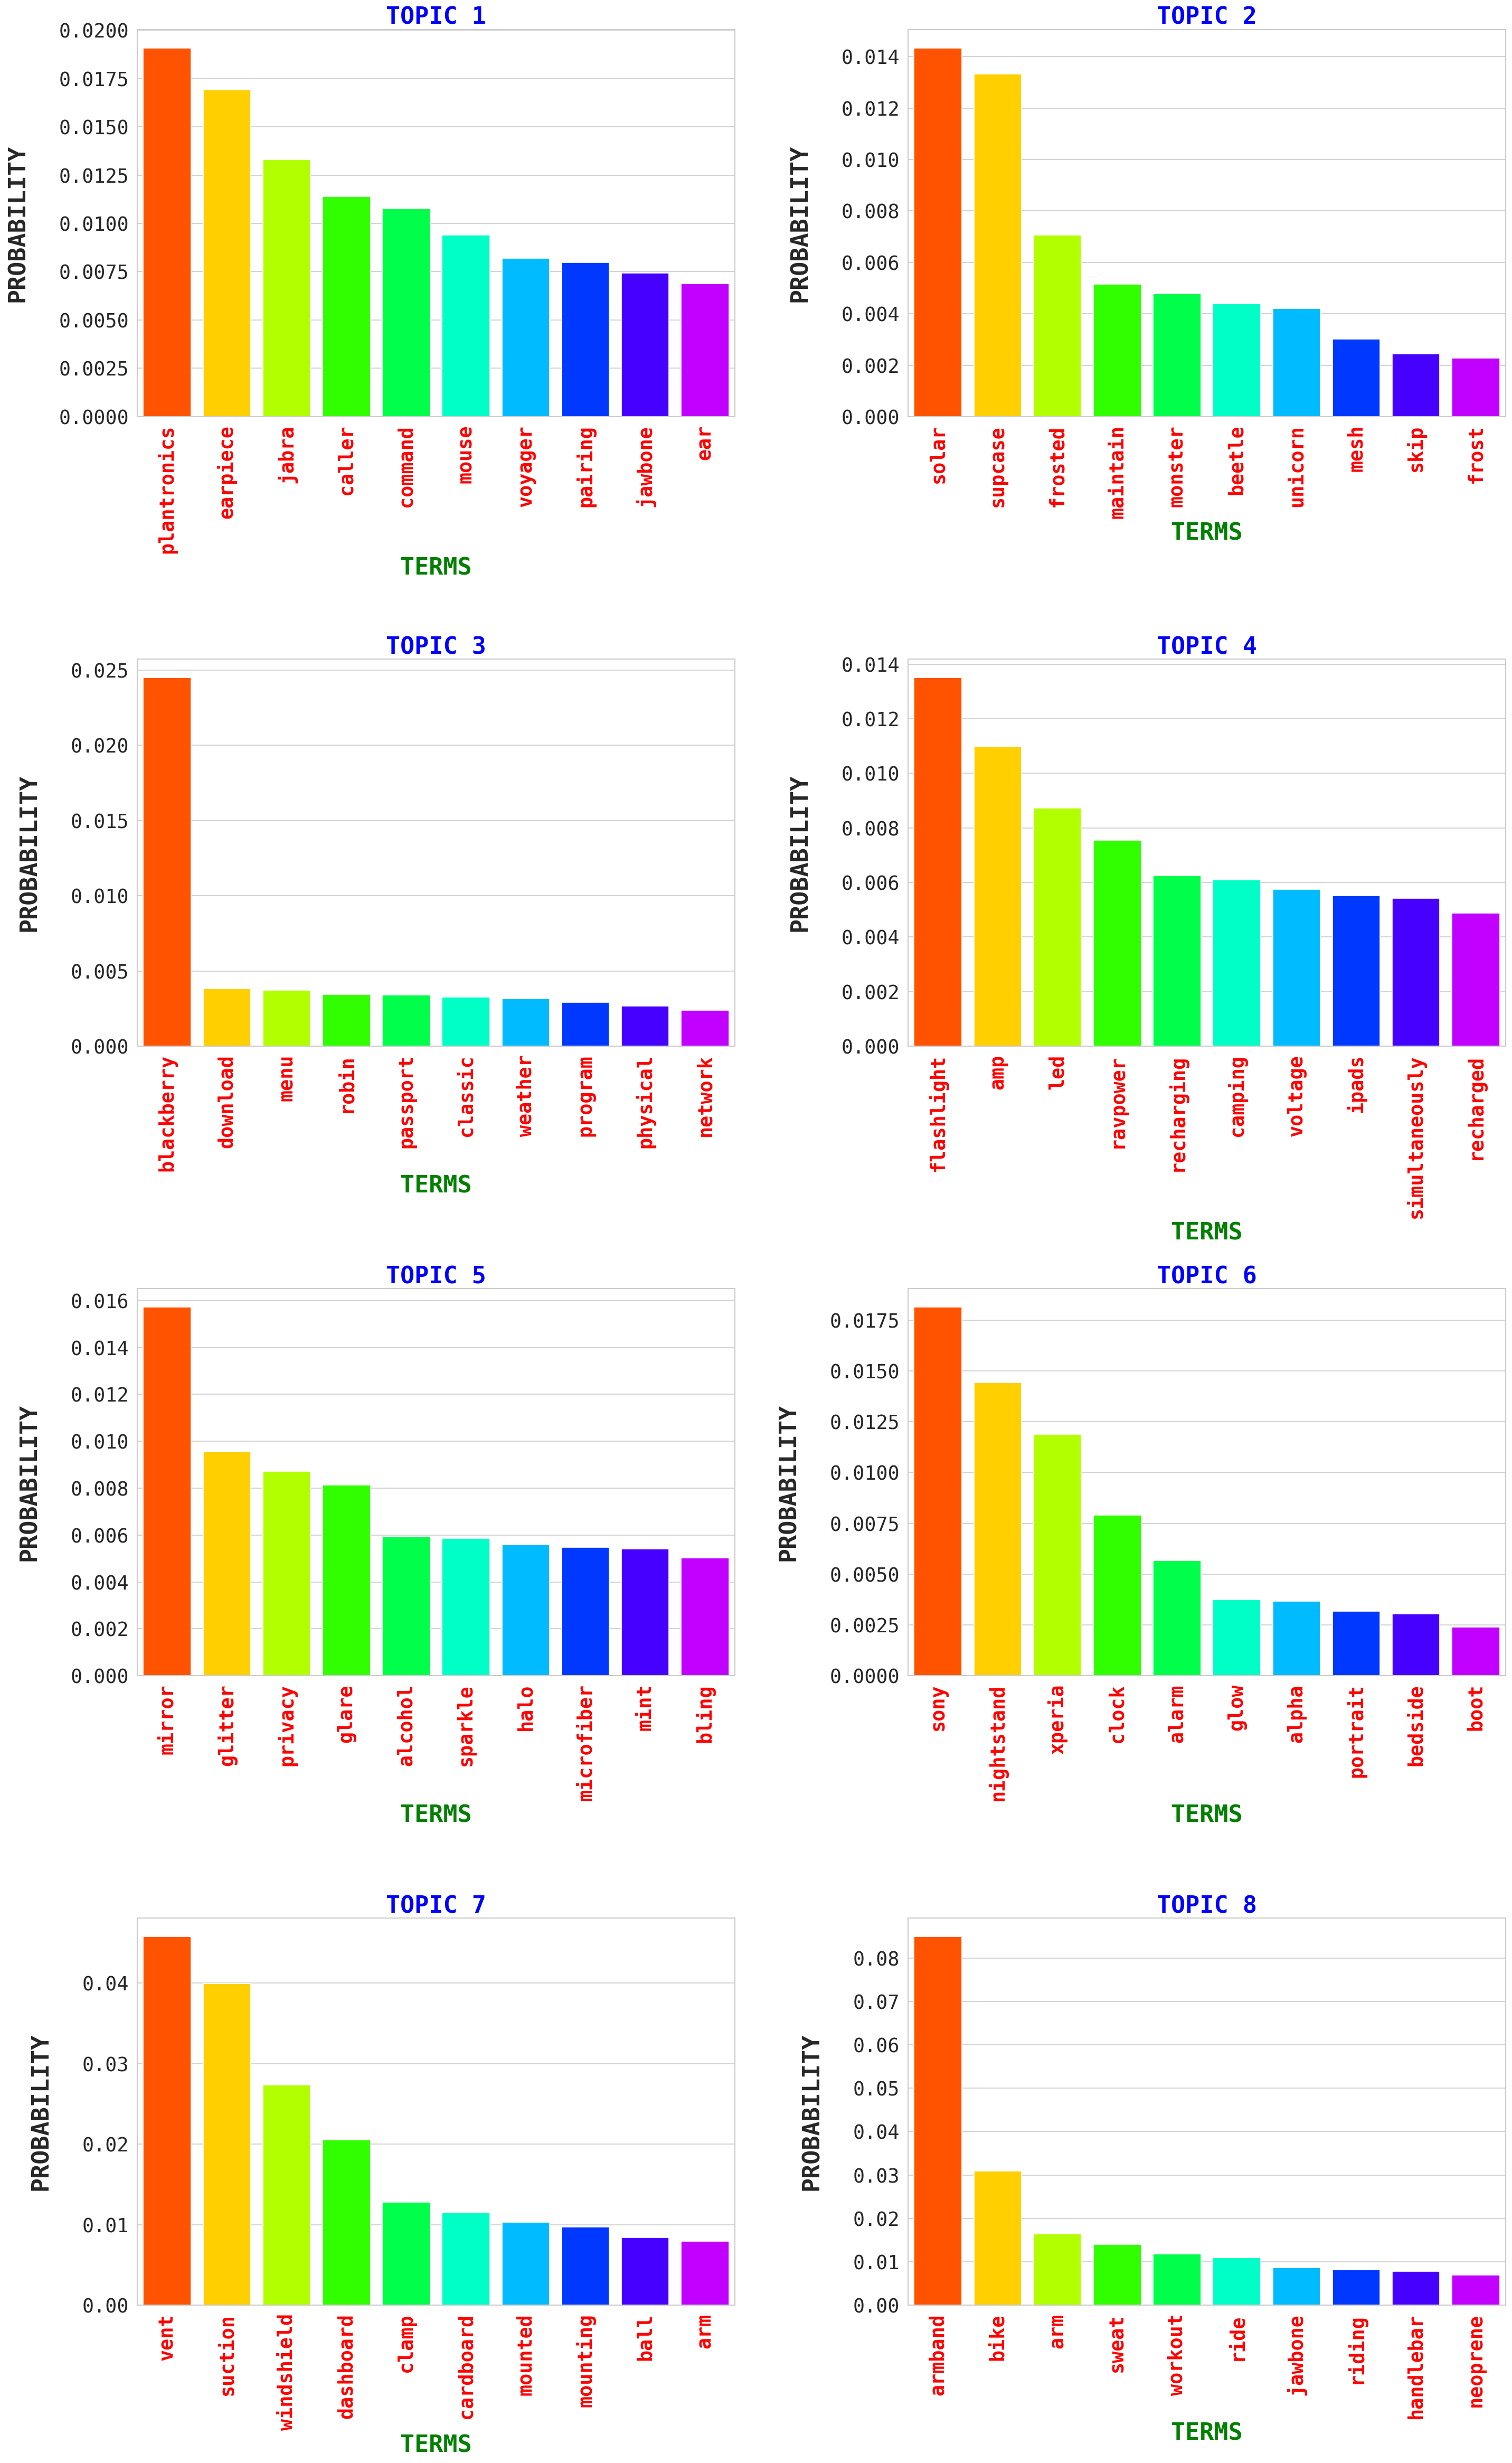

In [63]:
plt.figure(figsize=(25,40),dpi=120)
sns.set(context='notebook',style='whitegrid',palette='dark',font='monospace',font_scale=2)
for i in range(8): #showing 10 topics
    topic=pd.DataFrame(lda_model.show_topic(i), columns=['term','prob'])    
    plt.subplot(4,2,i+1)
    topics='TOPIC '+str(i+1)+''
    m=sns.barplot(y='prob', x='term', data=topic, palette='gist_rainbow',saturation=35)
    m.set_xticklabels(m.get_xticklabels(),rotation=90,weight='bold',color='red')
    plt.title(topics,fontsize=27,weight='bold',color='blue')          
    plt.xlabel('TERMS',fontsize=27,weight='bold',color='green')
    plt.ylabel('PROBABILITY\n',fontsize=27,weight='bold')
plt.tight_layout(pad=2, h_pad=1, w_pad=2)
plt.show()

`Function to find the dominant topic in each review`

In [64]:
def dominant_topic(ldamodel, corpus, texts):

    sent_topics_df = pd.DataFrame() 

    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)

        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:# =&gt; dominant topic
                wp = ldamodel.show_topic(topic_num,topn=30)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Topic', 'Perc', 'Keys']
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [65]:
dominant = dominant_topic(ldamodel=lda_model, corpus=bow_corpus, texts=crit['REVIEW']) 

In [66]:
dominant.drop(['REVIEW'],axis=1,inplace=True)

In [67]:
Final=pd.concat([crit,dominant],axis=1)

In [68]:
Final.head(10)

,IC,DESCRIPTION,REVIEW,MAXIMUM,AVERAGE,MINIMUM,TOKENIZED_REVIEW,Topic,Perc,Keys
0,B005NF5NTK,{'Color:': ' Black'},['performance poor babysit turn stop charging ...,871,51,59,"[performance, poor, babysit, turn, stop, charg...",3.0,0.7805,"flashlight, amp, led, ravpower, recharging, ca..."
1,B00VH88CJ0,{'Color:': ' Black'},"['good charger', 'love charger anker home char...",915,19,31,"[good, charger, love, charger, anker, home, ch...",3.0,0.6516,"flashlight, amp, led, ravpower, recharging, ca..."
2,B019PV2I3G,"{'Size:': ' 6ft', 'Color:': ' Red'}","['love cheep feeling product', 'short highly d...",856,23,56,"[love, cheep, feeling, product, short, highly,...",30.0,0.9191,"braided, usbc, certified, nylon, powerline, pi..."
3,B00X5RV14Y,{'Color:': ' Black'},"['charge droid ipad', 'power house work easy c...",881,24,20,"[charge, droid, ipad, power, house, easy, carr...",3.0,0.8308,"flashlight, amp, led, ravpower, recharging, ca..."
4,B00P7N0320,{'Color:': ' Black'},"['charge phone perfectly look pretty', 'arrive...",869,20,29,"[charge, phone, perfectly, look, pretty, arriv...",3.0,0.8360,"flashlight, amp, led, ravpower, recharging, ca..."
5,B018JW3EOY,{'Color:': ' Black'},"['battery often fit bill carrying', 'birthday ...",866,22,30,"[battery, often, fit, bill, carrying, birthday...",3.0,0.8293,"flashlight, amp, led, ravpower, recharging, ca..."
6,B00MQSMDYU,{'Color:': ' Black-16750'},['update issue registration corrected star hap...,750,24,45,"[update, issue, registration, corrected, star,...",3.0,0.8841,"flashlight, amp, led, ravpower, recharging, ca..."
7,B00G7UY3EG,{'Format:': ' Wireless Phone Accessory'},"['work good product happy', 'galaxy prefer cha...",599,29,121,"[good, product, happy, galaxy, prefer, chargin...",30.0,0.6813,"braided, usbc, certified, nylon, powerline, pi..."
8,B00D856NOG,{'Color:': ' Black'},['little phone stand prop phone ordered wife n...,643,24,23,"[little, phone, stand, prop, phone, ordered, w...",5.0,0.4030,"sony, nightstand, xperia, clock, alarm, glow, ..."
9,B0092KJ9BU,"{'Color:': ' Black', 'Package Type:': ' Standa...",['excellent bluetooth piece simply best contro...,505,67,105,"[excellent, bluetooth, piece, simply, best, co...",0.0,0.7811,"plantronics, earpiece, jabra, caller, command,..."


`Saving the model`

In [69]:
joblib.dump(lda_model,'productreview.pkl')

['productreview.pkl']

`Saving dataframe to JSON`

In [70]:
Final.to_json(r'C:\Users\mishr\review\REVIEW.json')